### The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from wordcloud import WordCloud
import string
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import gensim
import string

In [2]:
df=pd.read_csv("E:\\My ds project 1-spam\\spam (1).csv",encoding="ISO-8859-1")
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [3]:
df['v2'][0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [4]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

# Rename the column name

In [5]:
df.rename(columns={'v1':'Target','v2':'SMS'},inplace=True)

In [6]:
df=df.iloc[:,[1,0]]

In [7]:
df

,SMS,Target
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam
5568,Will Ì_ b going to esplanade fr home?,ham
5569,"Pity, * was in mood for that. So...any other s...",ham
5570,The guy did some bitching but I acted like i'd...,ham


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMS     5572 non-null   object
 1   Target  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


# Check for null values

In [9]:
df.isnull().sum()

SMS       0
Target    0
dtype: int64

In [10]:
df[df.duplicated()==True]

,SMS,Target
102,As per your request 'Melle Melle (Oru Minnamin...,ham
153,As per your request 'Melle Melle (Oru Minnamin...,ham
206,"As I entered my cabin my PA said, '' Happy B'd...",ham
222,"Sorry, I'll call later",ham
325,No calls..messages..missed calls,ham
...,...,...
5524,You are awarded a SiPix Digital Camera! call 0...,spam
5535,"I know you are thinkin malaria. But relax, chi...",ham
5539,Just sleeping..and surfing,ham
5553,Hahaha..use your brain dear,ham


# Check for duplicates

In [11]:
df.duplicated().sum()

403

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
df.shape

(5169, 2)

# Check for count of spam and ham in  given dataset

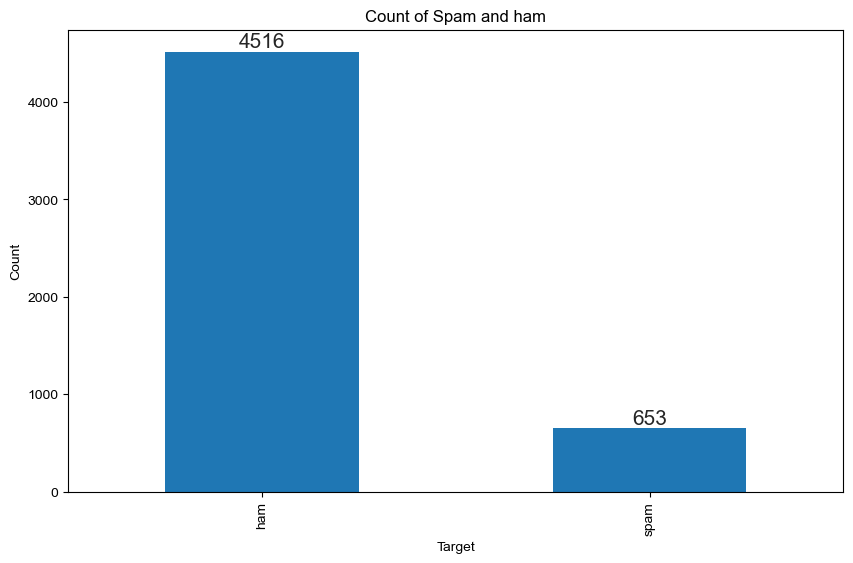

In [14]:
plt.figure(figsize=(10,6))
df['Target'].value_counts().plot(kind='bar')
plt.xlabel('Target')
plt.ylabel('Count')
plt.title("Count of Spam and ham")
sns.set_style('white')
for i,j in enumerate(df['Target'].value_counts()):
    plt.text(i,j,str(j),ha='center',va='bottom',fontsize=15)
plt.show()

# The given dataset is imbalanced so we have to upsample the minority classes

In [15]:
words=' '.join(df['SMS']).split()

num_count = 0
text_count = 0
punct_count = 0
others=0

for char in words:
    if char.isalpha():
        text_count+=1
    elif char.isdigit():
        num_count+=1
    elif char in string.punctuation:
        punct_count+=1
    else:
        others+=1
        
count_dict={'Text':text_count,'Number':num_count,'Punctuation':punct_count,'Others':others} 

char_series=pd.Series(count_dict)

Text(0.5, 1.0, 'No of text string')

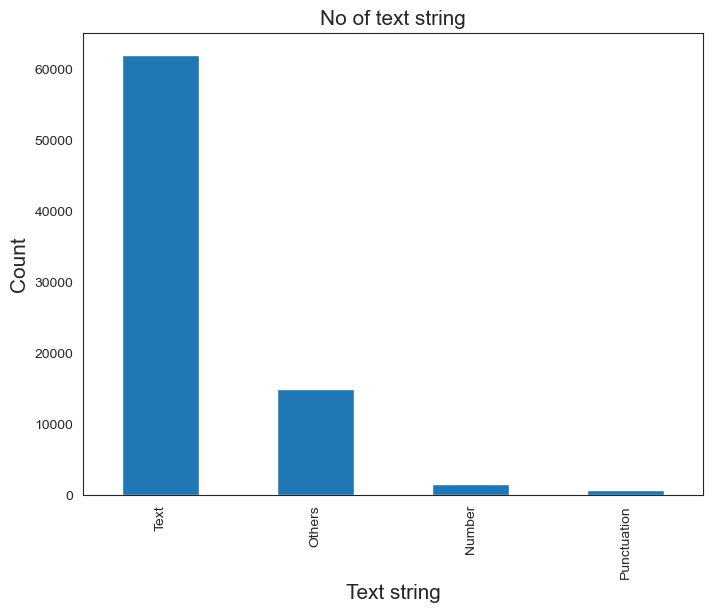

In [16]:
fig=plt.figure(figsize=(8,6))
char_series.sort_values(ascending=False).plot(kind='bar')
plt.xlabel('Text string',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title('No of text string',fontsize=15)

# Stopwords

In [17]:
stop_words = stopwords.words("english")
from collections import defaultdict
review_sw=defaultdict(int)
for char in words:
    if char in stop_words:
        review_sw[char]+=1
            

Text(0.5, 1.0, 'Most Frequently occured stopwords')

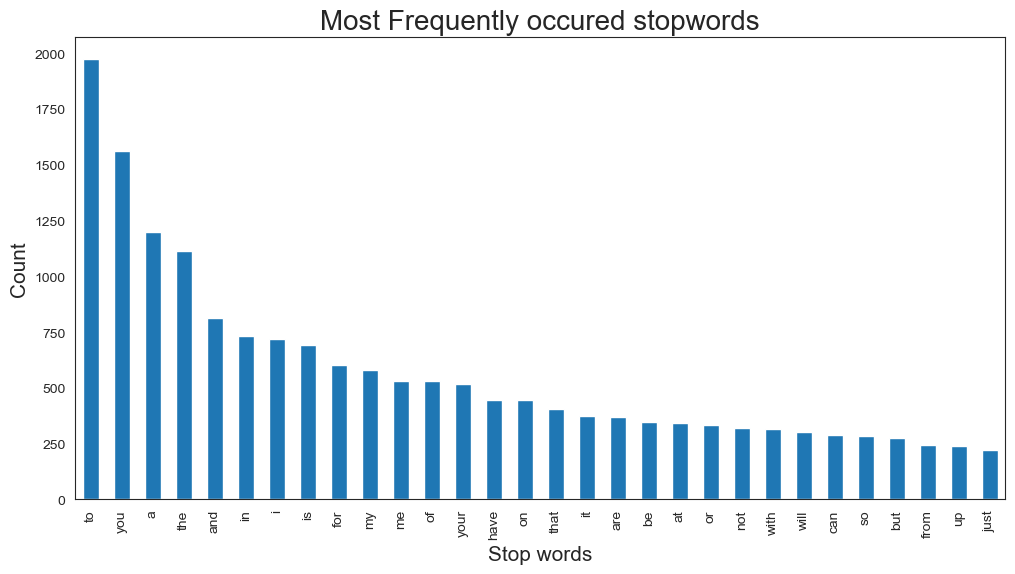

In [18]:
stop_series=pd.Series(review_sw).sort_values(ascending=False)
plt.figure(figsize=(12,6))
stop_series.head(30).plot(kind='bar')
plt.xlabel('Stop words',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title('Most Frequently occured stopwords',fontsize=20)

# Analysing the ham and spam words

In [19]:
ham_words=defaultdict(int)
spam_words=defaultdict(int)

for i,j in zip(df.SMS,df.Target):
    words=i.split()
    #sentence=df.Target
    if j=='ham':
        for w in words:
            ham_words[w]+=1
    elif j=='spam':
        for w in words:
            spam_words[w]+=1

In [20]:
ham_list=list(ham_words.keys())
spam_list=list(spam_words.keys())

# Analysis on Ham words

In [21]:
def plot_cloud(workcloud):
    plt.figure(figsize=(30,40))
    plt.imshow(workcloud)
    plt.axis('off')

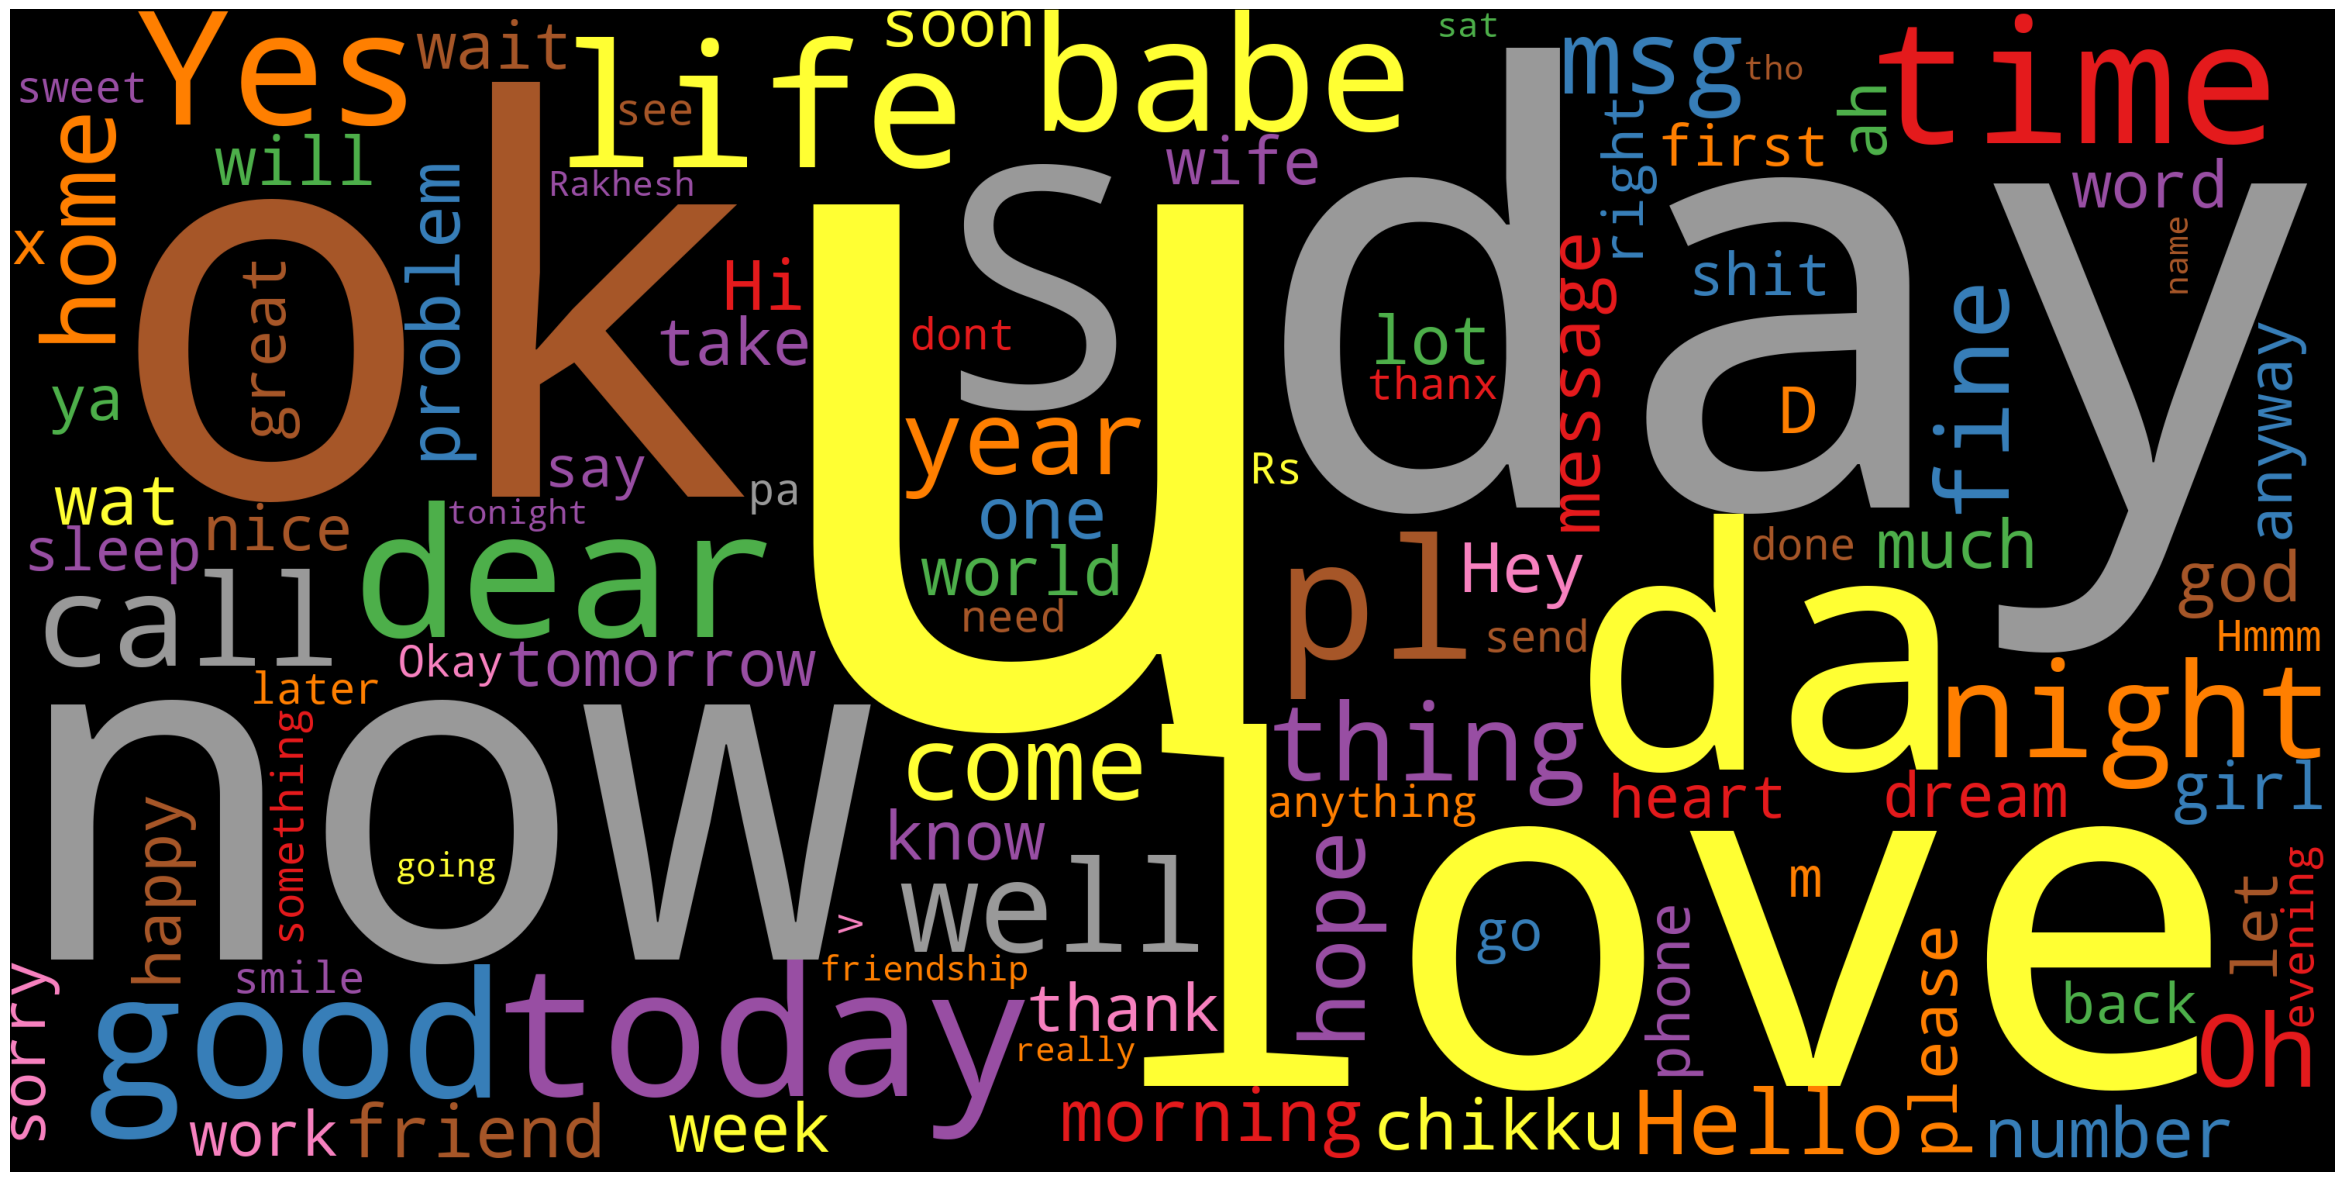

In [22]:
ham_workcloud=WordCloud(width=3000,height=1500,background_color='black',max_words=100,colormap='Set1').generate(' '.join(ham_list))
plot_cloud(ham_workcloud)

# Most occuring ham words

In [23]:
ham_words=[]
spam_words=[]

for i,j in zip(df.SMS,df.Target):
    words=i.split()
    if j=='ham':
        ham_words.extend(words)
    elif j=='spam':
        spam_words.extend(words)

<AxesSubplot:>

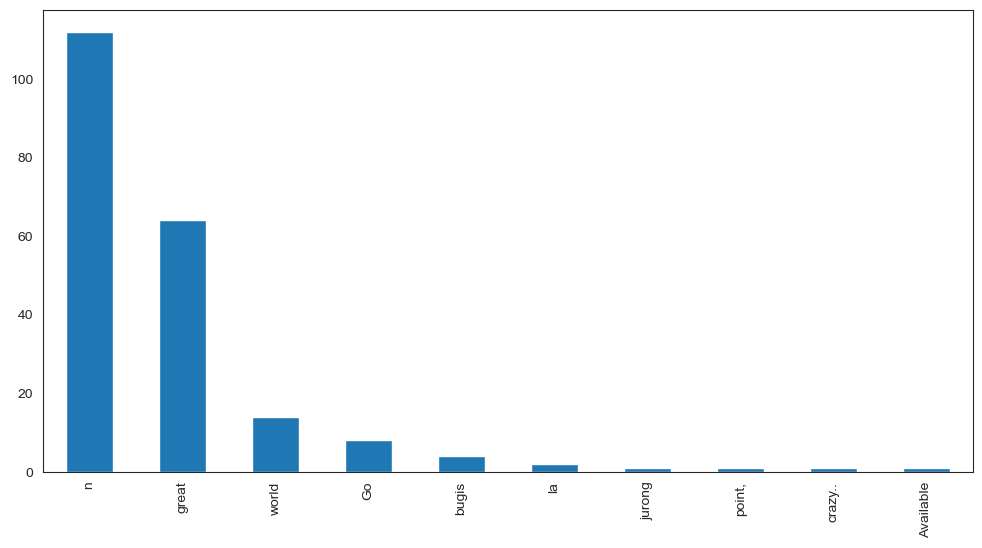

In [24]:
ham_cnt=defaultdict(int)

for char in ham_words:
    if char not in stop_words and char not in string.punctuation:
        ham_cnt[char]+=1
plt.figure(figsize=(12,6))
ham_series=pd.Series(ham_cnt)
ham_series.head(10).sort_values(ascending=False).plot(kind='bar')

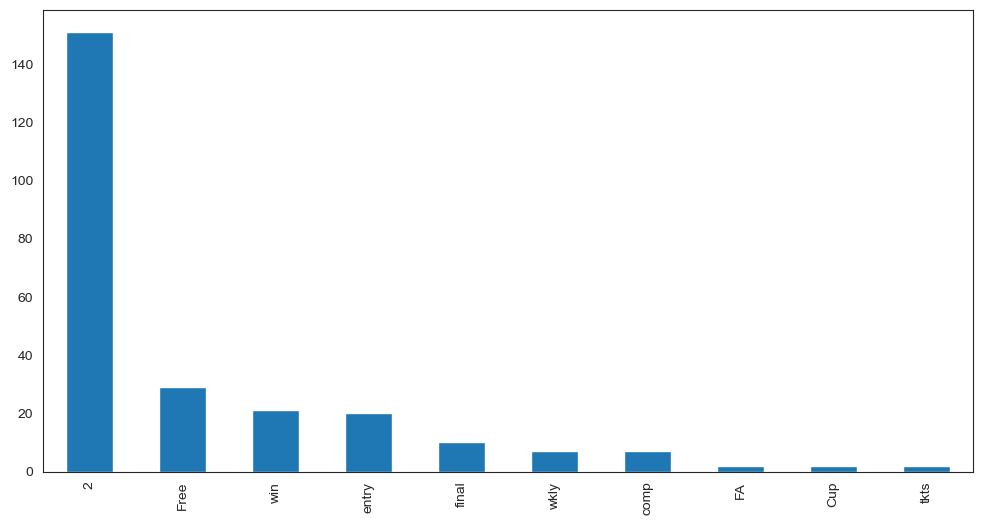

In [25]:
spam_cnt=defaultdict(int)
for char in spam_words:
    if char not in stop_words and char not in string.punctuation:
        spam_cnt[char]+=1
plt.figure(figsize=(12,6))
spam_series=pd.Series(spam_cnt)
spam_series.head(10).sort_values(ascending=False).plot(kind='bar')
plt.show()

# Unigram,bigram,trigram of ham words

Text(0.5, 1.0, 'Top 30 unigrams in ham')

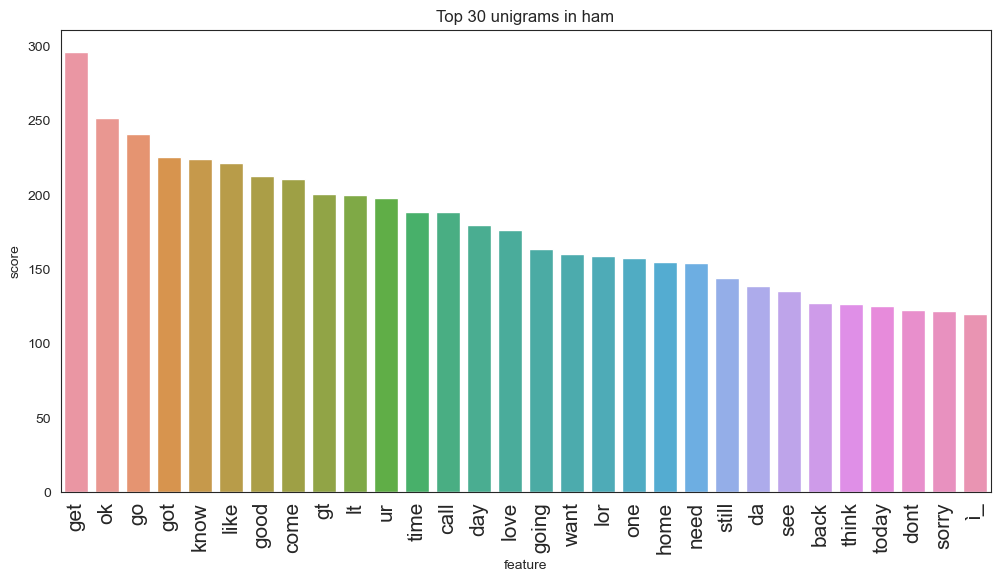

In [102]:
vectorizer = TfidfVectorizer(ngram_range=(1,1),stop_words=stop_words)

X = vectorizer.fit_transform(ham_words)

features = vectorizer.get_feature_names_out()
scores = X.sum(axis=0).A1
df_features = pd.DataFrame({'feature': features, 'score': scores})

df_features = df_features.sort_values('score', ascending=False)
df1=df_features.head(30)
fig=plt.figure(figsize=(12,6))
sns.barplot(data=df1,x=df1['feature'],y=df1['score'])
plt.xticks(rotation=90,fontsize=15)
plt.title('Top 30 unigrams in ham')

In [103]:
features[1:10]

array(['0125698789', '0quit', '10', '100', '1000s', '1030', '11', '1120',
       '116'], dtype=object)

Text(0.5, 1.0, 'Top 30 unigrams in ham')

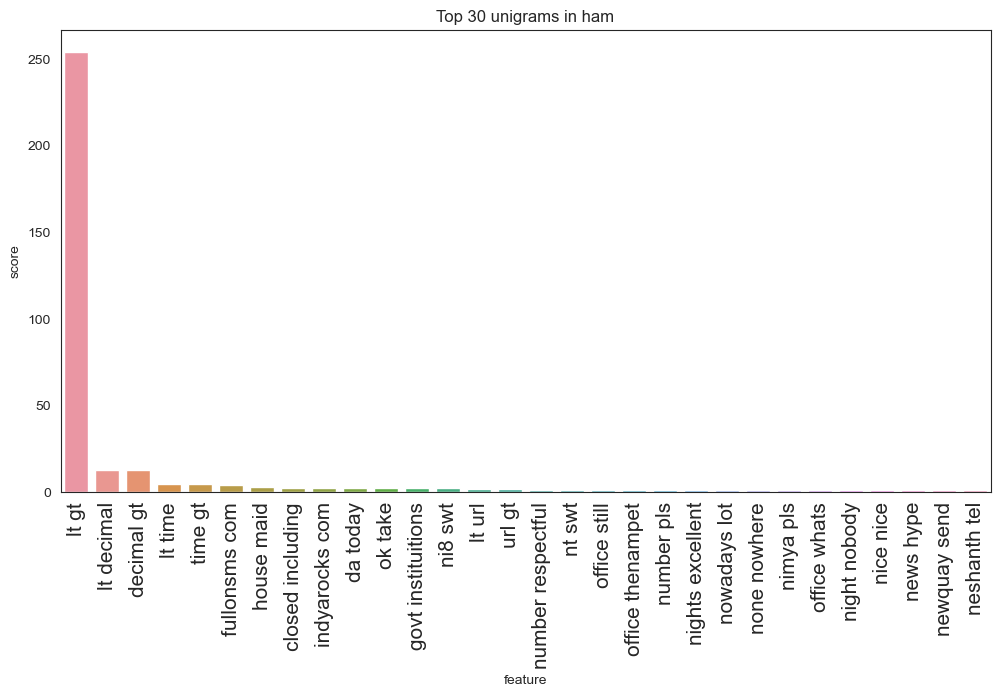

In [104]:
vectorizer = TfidfVectorizer(ngram_range=(2,2),stop_words=stop_words)

X = vectorizer.fit_transform(ham_words)

features = vectorizer.get_feature_names_out()
scores = X.sum(axis=0).A1
df_features = pd.DataFrame({'feature': features, 'score': scores})


df_features = df_features.sort_values('score', ascending=False)
df1=df_features.head(30)
fig=plt.figure(figsize=(12,6))
sns.barplot(data=df1,x=df1['feature'],y=df1['score'])
plt.xticks(rotation=90,fontsize=15)
plt.title('Top 30 unigrams in ham')

In [105]:
features

array(['10 10', '10 1mega', '10 30', '11 48', '12 000pes', '12 30',
       '15 26', '1apple day', '1lemon day', '22 65', '2day love',
       '2nite tell', '33 65', '4thnov behind', '60 400thousad', '61 66',
       '65 61', '66 382', '95 pax', 'aathi love', 'achan amma',
       'affections amp', 'ages ring', 'ago cusoon', 'ah gee', 'ah sen',
       'alaikkum pride', 'album quite', 'alive better', 'allah meet',
       'allah rakhesh', 'already sabarish', 'alright okay',
       'alternative hope', 'ambrith madurai', 'amma rakhesh',
       'ammae life', 'amp take', 'andrews boy', 'apples pairs',
       'ar praveesh', 'ard ìä', 'asap ok', 'aslamalaikkum insha',
       'atm sms', 'auction punj', 'babe sozi', 'baby hope', 'basq ihave',
       'bbd pooja', 'bbd thts', 'beautiful may', 'bedrm 900',
       'bedroom love', 'beer rs', 'best congrats', 'best rply',
       'bevies waz', 'bless get', 'blogspot com', 'blood blood',
       'blood send', 'born please', 'bout xx', 'brilliant 1thing',
   

Text(0.5, 1.0, 'Top 30 unigrams in ham')

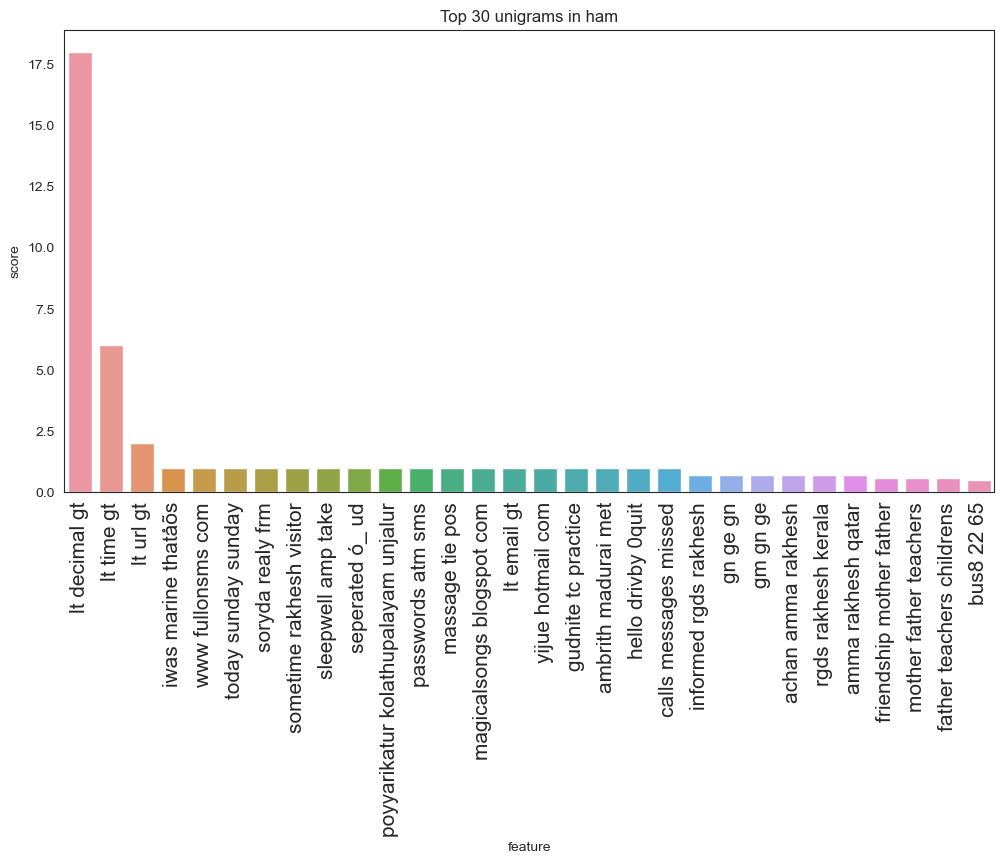

In [106]:
vectorizer = TfidfVectorizer(ngram_range=(3,3),stop_words=stop_words)

X = vectorizer.fit_transform(ham_words)

features = vectorizer.get_feature_names_out()
scores = X.sum(axis=0).A1
df_features = pd.DataFrame({'feature': features, 'score': scores})


df_features = df_features.sort_values('score', ascending=False)
df1=df_features.head(30)
fig=plt.figure(figsize=(12,6))
sns.barplot(data=df1,x=df1['feature'],y=df1['score'])
plt.xticks(rotation=90,fontsize=15)
plt.title('Top 30 unigrams in ham')

# Unigram,bigram,trigram of Spam words

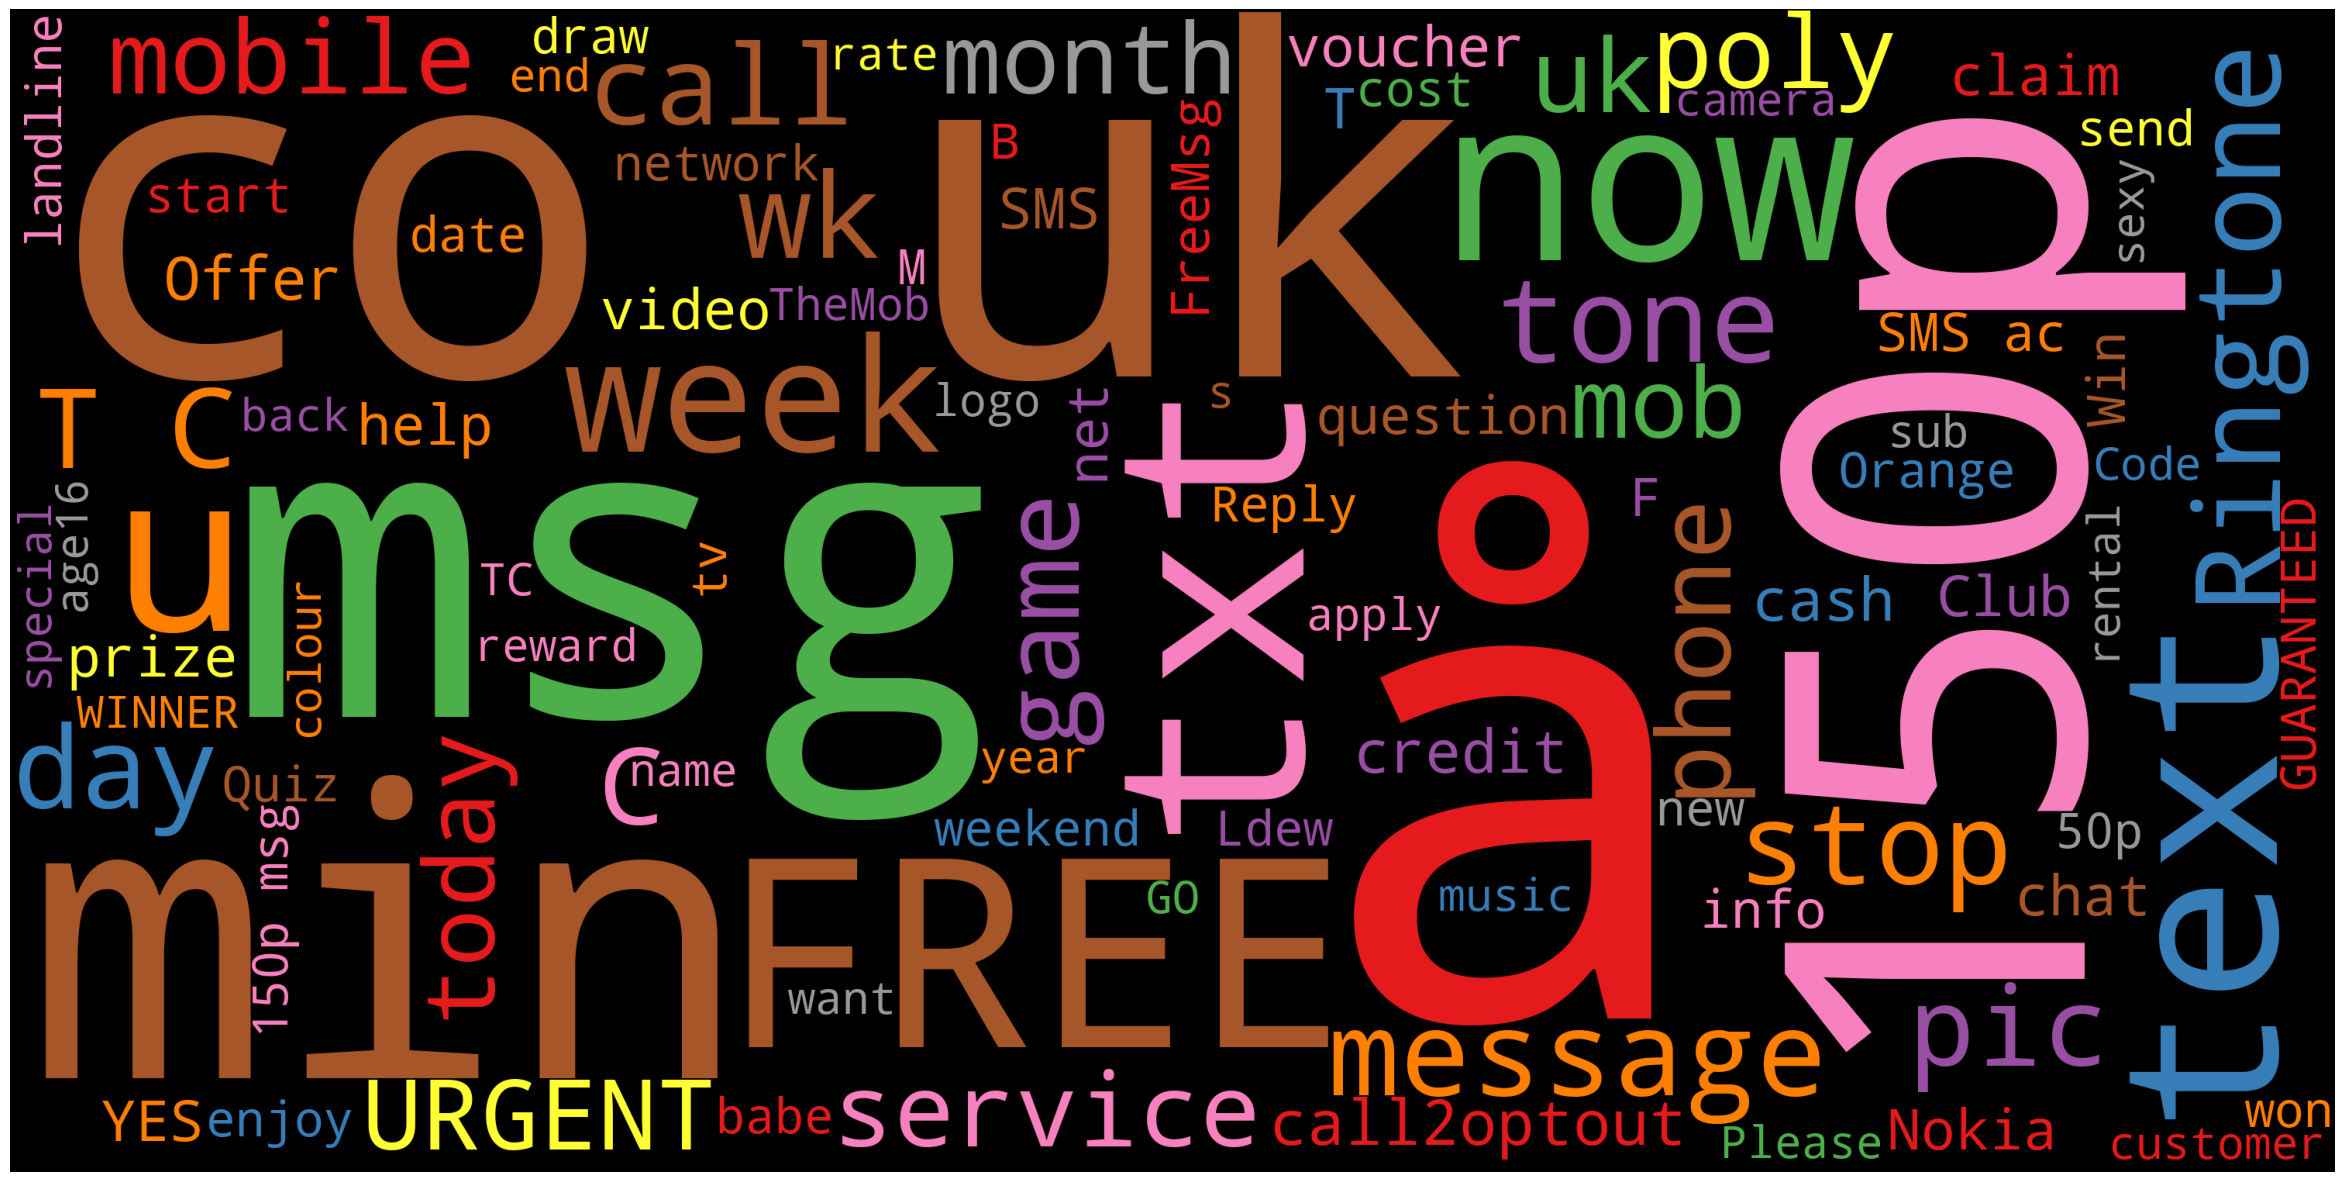

In [107]:
spam_workcloud=WordCloud(width=3000,height=1500,background_color='black',max_words=100,colormap='Set1').generate(' '.join(spam_list))
plot_cloud(spam_workcloud)

Text(0.5, 1.0, 'Top 30 unigrams in Spam')

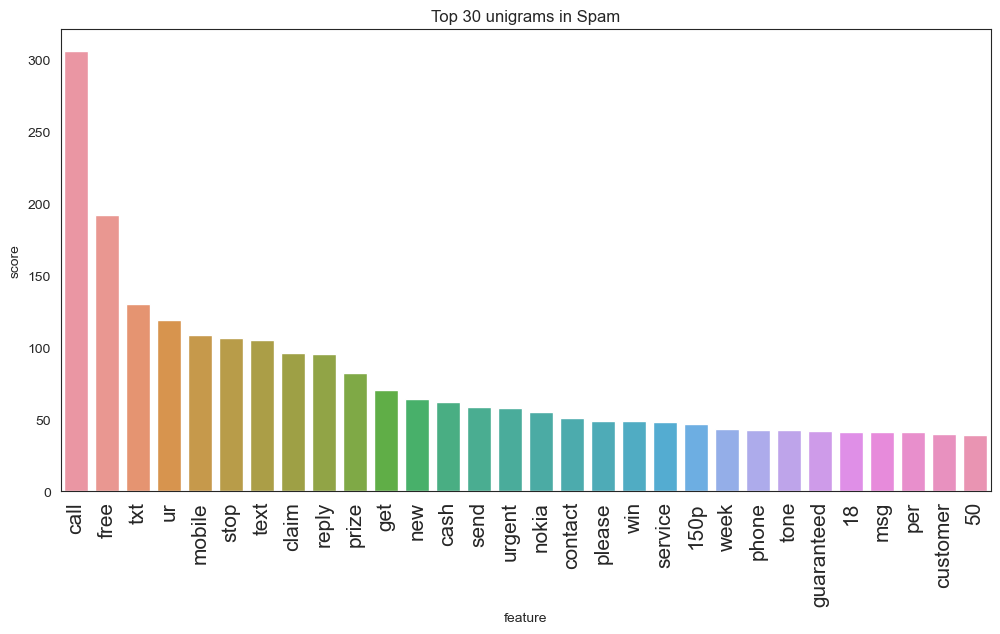

In [108]:
vectorizer = TfidfVectorizer(ngram_range=(1,1),stop_words=stop_words)

X = vectorizer.fit_transform(spam_words)

features = vectorizer.get_feature_names_out()
scores = X.sum(axis=0).A1
df_features = pd.DataFrame({'feature': features, 'score': scores})


df_features = df_features.sort_values('score', ascending=False)
df1=df_features.head(30)
fig=plt.figure(figsize=(12,6))
sns.barplot(data=df1,x=df1['feature'],y=df1['score'])
plt.xticks(rotation=90,fontsize=15)
plt.title('Top 30 unigrams in Spam')

Text(0.5, 1.0, 'Top 30 unigrams in Spam')

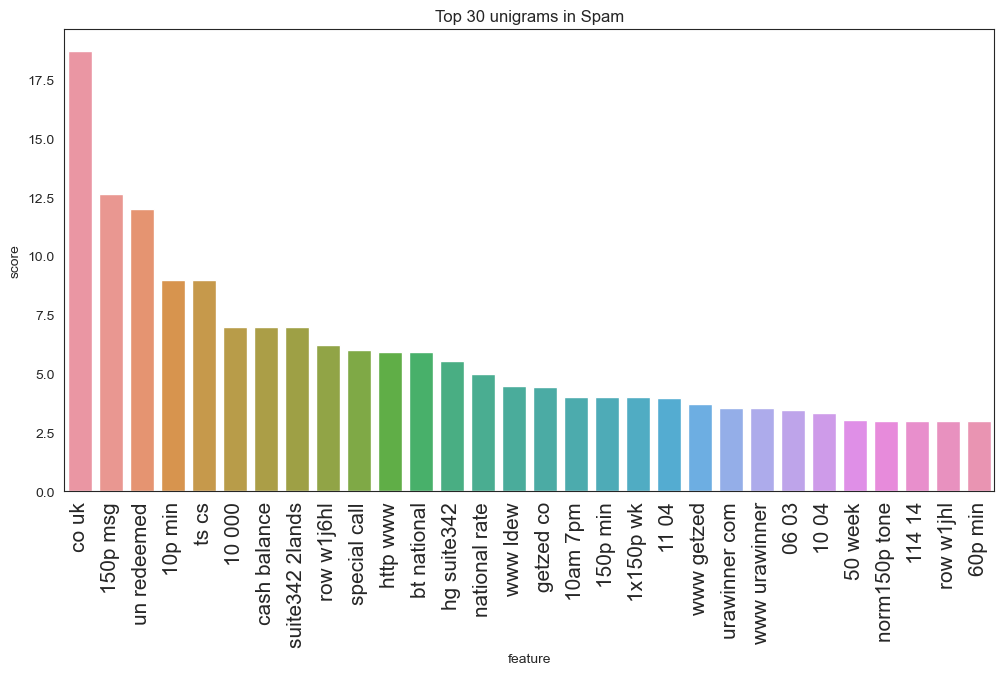

In [109]:
vectorizer = TfidfVectorizer(ngram_range=(2,2),stop_words=stop_words)

X = vectorizer.fit_transform(spam_words)

features = vectorizer.get_feature_names_out()
scores = X.sum(axis=0).A1
df_features = pd.DataFrame({'feature': features, 'score': scores})


df_features = df_features.sort_values('score', ascending=False)
df1=df_features.head(30)
fig=plt.figure(figsize=(12,6))
sns.barplot(data=df1,x=df1['feature'],y=df1['score'])
plt.xticks(rotation=90,fontsize=15)
plt.title('Top 30 unigrams in Spam')

Text(0.5, 1.0, 'Top 30 unigrams in Spam')

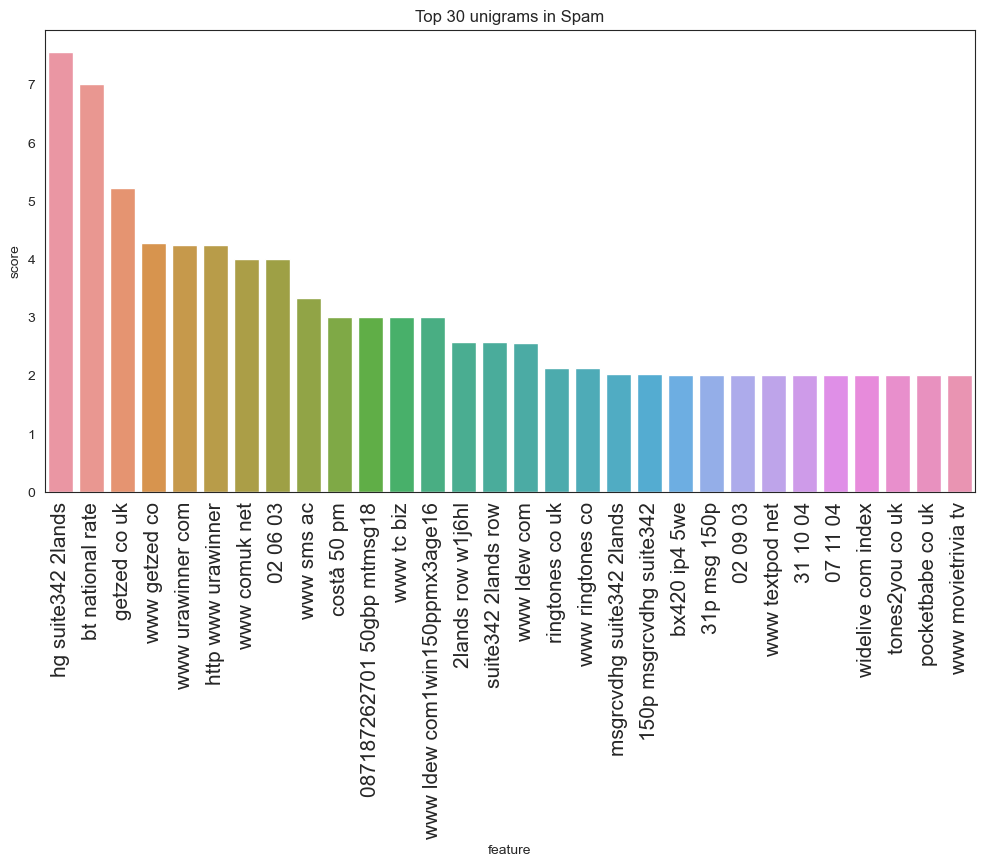

In [110]:
vectorizer = TfidfVectorizer(ngram_range=(3,3),stop_words=stop_words)

X = vectorizer.fit_transform(spam_words)

features = vectorizer.get_feature_names_out()
scores = X.sum(axis=0).A1
df_features = pd.DataFrame({'feature': features, 'score': scores})


df_features = df_features.sort_values('score', ascending=False)
df1=df_features.head(30)
fig=plt.figure(figsize=(12,6))
sns.barplot(data=df1,x=df1['feature'],y=df1['score'])
plt.xticks(rotation=90,fontsize=15)
plt.title('Top 30 unigrams in Spam')

# Length of ham and spam

In [33]:
df1=df.copy()

df1['Length']=df1['SMS'].apply(len)

In [ ]:
df1['Length'].hist()

# Will check the most common unigrams in positive,negative,neutral reviews by preprocess the text

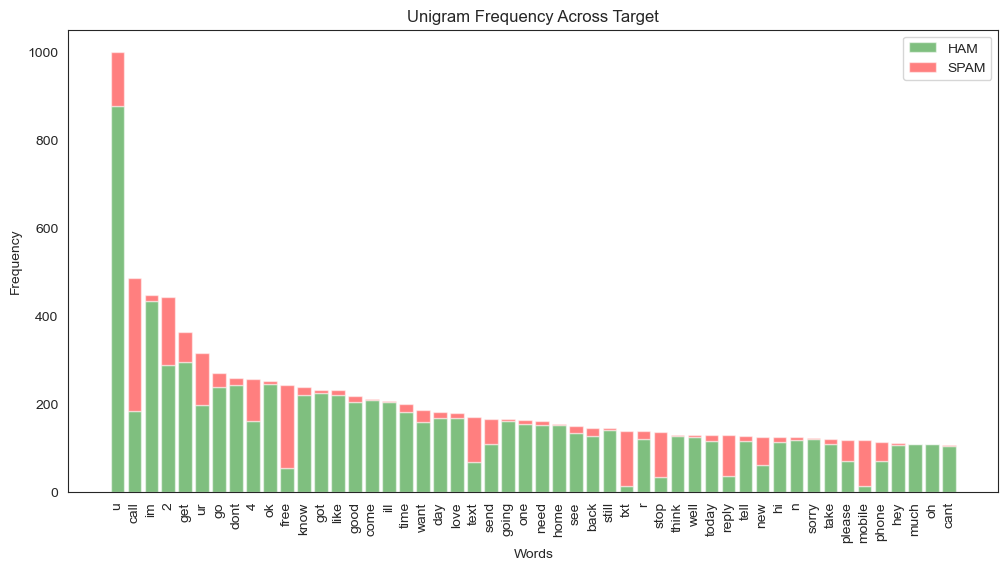

In [35]:
def preprocess(text):
    
    text=text.lower()
    
    text=text.translate(str.maketrans(" "," ",string.punctuation))
    
    stop_words=set(stopwords.words('english'))
    
    text=[word for word in text.split() if word not in stop_words]
    
    return text

df1['unigram']=df1['SMS'].apply(lambda x:preprocess(x))

from collections import Counter

ham_counter=Counter()
spam_counter=Counter()

for i,row in df1.iterrows():
    tokens=row['unigram']
    sent=row['Target']
    if sent=='ham':
        ham_counter.update(tokens)
    elif sent=='spam':
        spam_counter.update(tokens)
        
common_words=set(ham_counter.keys())&set(spam_counter.keys())

top50_words=[x for x in sorted(common_words,key=lambda x:ham_counter[x]+spam_counter[x],reverse=True)[:50]]

fig, ax = plt.subplots(figsize=(12, 6))

for word in top50_words:
    ham_word=ham_counter[word]
    spam_word=spam_counter[word]
    ax.bar(word,ham_word,color='green',alpha=0.5)
    ax.bar(word,spam_word,color='red',alpha=0.5,bottom=ham_word)
    
ax.set_xlabel('Words')
ax.set_xticklabels(top50_words, rotation=90)
ax.set_ylabel('Frequency')
ax.set_title('Unigram Frequency Across Target')

# Add legend
ax.legend(['HAM', 'SPAM'])

# Show plot
plt.show()

In [36]:
from nltk.util import ngrams

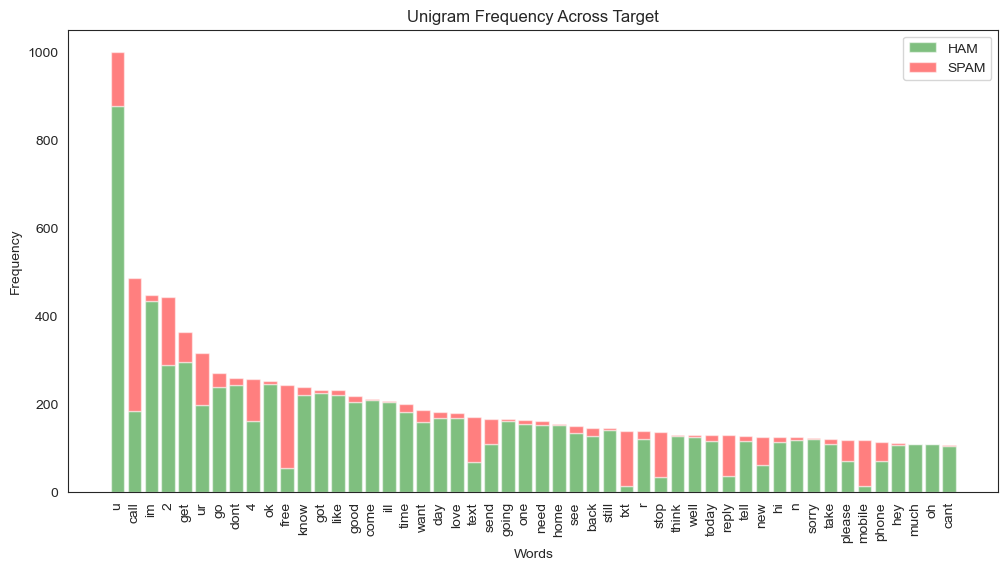

In [37]:
def preprocess(text):
    
    text=text.lower()
    
    text=text.translate(str.maketrans(" "," ",string.punctuation))
    
    stop_words=set(stopwords.words('english'))
    
    text=[word for word in text.split() if word not in stop_words]
    
    text=ngrams(text,2)
    
    n_grams_list = [" ".join(grams) for grams in text]
    
    return n_grams_list

df1['bigram']=df1['SMS'].apply(lambda x:preprocess(x))

from collections import Counter

ham_counter=Counter()
spam_counter=Counter()

for i,row in df1.iterrows():
    tokens=row['unigram']
    sent=row['Target']
    if sent=='ham':
        ham_counter.update(tokens)
    elif sent=='spam':
        spam_counter.update(tokens)
        
common_words=set(ham_counter.keys())&set(spam_counter.keys())

top50_words=[x for x in sorted(common_words,key=lambda x:ham_counter[x]+spam_counter[x],reverse=True)[:50]]

fig, ax = plt.subplots(figsize=(12, 6))

for word in top50_words:
    ham_word=ham_counter[word]
    spam_word=spam_counter[word]
    ax.bar(word,ham_word,color='green',alpha=0.5)
    ax.bar(word,spam_word,color='red',alpha=0.5,bottom=ham_word)
    
ax.set_xlabel('Words')
ax.set_xticklabels(top50_words, rotation=90)
ax.set_ylabel('Frequency')
ax.set_title('Unigram Frequency Across Target')

# Add legend
ax.legend(['HAM', 'SPAM'])

# Show plot
plt.show()

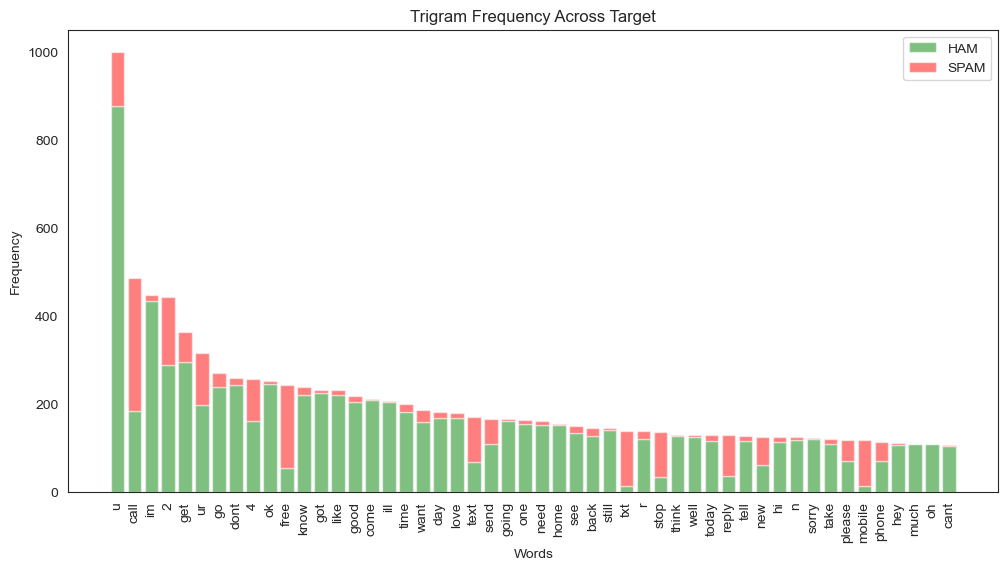

In [38]:
def preprocess(text):
    
    text=text.lower()
    
    text=text.translate(str.maketrans(" "," ",string.punctuation))
    
    stop_words=set(stopwords.words('english'))
    
    text=[word for word in text.split() if word not in stop_words]
    
    text=ngrams(text,3)
    
    n_grams_list = [" ".join(grams) for grams in text]
    
    return n_grams_list

df1['Trigram']=df1['SMS'].apply(lambda x:preprocess(x))

from collections import Counter

ham_counter=Counter()
spam_counter=Counter()

for i,row in df1.iterrows():
    tokens=row['unigram']
    sent=row['Target']
    if sent=='ham':
        ham_counter.update(tokens)
    elif sent=='spam':
        spam_counter.update(tokens)
        
common_words=set(ham_counter.keys())&set(spam_counter.keys())

top50_words=[x for x in sorted(common_words,key=lambda x:ham_counter[x]+spam_counter[x],reverse=True)[:50]]

fig, ax = plt.subplots(figsize=(12, 6))

for word in top50_words:
    ham_word=ham_counter[word]
    spam_word=spam_counter[word]
    ax.bar(word,ham_word,color='green',alpha=0.5)
    ax.bar(word,spam_word,color='red',alpha=0.5,bottom=ham_word)
    
ax.set_xlabel('Words')
ax.set_xticklabels(top50_words, rotation=90)
ax.set_ylabel('Frequency')
ax.set_title('Trigram Frequency Across Target')

# Add legend
ax.legend(['HAM', 'SPAM'])

# Show plot
plt.show()

# Text preprocessing

In [39]:
# Tokenization
# Lower case conversion
# Removing punctuations,urls,numbers,emojis
# removing stopwords
# Lemmatization
# Stemming

In [40]:
df1=df.copy()

# Tokens & Lowering the tokens

In [41]:
def tokens(text):
    text=(text.lower()).split()
    return text

In [42]:
df1['Tokens']=df1['SMS'].apply(tokens)
df1

,SMS,Target,Tokens
0,"Go until jurong point, crazy.. Available only ...",ham,"[go, until, jurong, point,, crazy.., available..."
1,Ok lar... Joking wif u oni...,ham,"[ok, lar..., joking, wif, u, oni...]"
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,U dun say so early hor... U c already then say...,ham,"[u, dun, say, so, early, hor..., u, c, already..."
4,"Nah I don't think he goes to usf, he lives aro...",ham,"[nah, i, don't, think, he, goes, to, usf,, he,..."
...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam,"[this, is, the, 2nd, time, we, have, tried, 2,..."
5568,Will Ì_ b going to esplanade fr home?,ham,"[will, ì_, b, going, to, esplanade, fr, home?]"
5569,"Pity, * was in mood for that. So...any other s...",ham,"[pity,, *, was, in, mood, for, that., so...any..."
5570,The guy did some bitching but I acted like i'd...,ham,"[the, guy, did, some, bitching, but, i, acted,..."


# Removing punctuation

In [43]:
def punkt(text):
    
    text=' '.join(text)
    
    text=text.translate(str.maketrans(" "," ",string.punctuation))
    
    return text.split()

In [44]:
df1['Remove punkt']=df1['Tokens'].apply(punkt)
df1

,SMS,Target,Tokens,Remove punkt
0,"Go until jurong point, crazy.. Available only ...",ham,"[go, until, jurong, point,, crazy.., available...","[go, until, jurong, point, crazy, available, o..."
1,Ok lar... Joking wif u oni...,ham,"[ok, lar..., joking, wif, u, oni...]","[ok, lar, joking, wif, u, oni]"
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,U dun say so early hor... U c already then say...,ham,"[u, dun, say, so, early, hor..., u, c, already...","[u, dun, say, so, early, hor, u, c, already, t..."
4,"Nah I don't think he goes to usf, he lives aro...",ham,"[nah, i, don't, think, he, goes, to, usf,, he,...","[nah, i, dont, think, he, goes, to, usf, he, l..."
...,...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam,"[this, is, the, 2nd, time, we, have, tried, 2,...","[this, is, the, 2nd, time, we, have, tried, 2,..."
5568,Will Ì_ b going to esplanade fr home?,ham,"[will, ì_, b, going, to, esplanade, fr, home?]","[will, ì, b, going, to, esplanade, fr, home]"
5569,"Pity, * was in mood for that. So...any other s...",ham,"[pity,, *, was, in, mood, for, that., so...any...","[pity, was, in, mood, for, that, soany, other,..."
5570,The guy did some bitching but I acted like i'd...,ham,"[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitching, but, i, acted,..."


# Removing urls

In [45]:
import re

def urls(text):
    text=' '.join(text)
    # Remove URLs starting with http:// or https://
    text = re.sub(r'https?://\S+', '', text)
    
    # Remove URLs starting with www.
    text = re.sub(r'www\.\S+', '', text)
    
    return text.split()

In [46]:
df1['Urls']=df1['Remove punkt'].apply(urls)
df1

,SMS,Target,Tokens,Remove punkt,Urls
0,"Go until jurong point, crazy.. Available only ...",ham,"[go, until, jurong, point,, crazy.., available...","[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazy, available, o..."
1,Ok lar... Joking wif u oni...,ham,"[ok, lar..., joking, wif, u, oni...]","[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,U dun say so early hor... U c already then say...,ham,"[u, dun, say, so, early, hor..., u, c, already...","[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, so, early, hor, u, c, already, t..."
4,"Nah I don't think he goes to usf, he lives aro...",ham,"[nah, i, don't, think, he, goes, to, usf,, he,...","[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, i, dont, think, he, goes, to, usf, he, l..."
...,...,...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam,"[this, is, the, 2nd, time, we, have, tried, 2,...","[this, is, the, 2nd, time, we, have, tried, 2,...","[this, is, the, 2nd, time, we, have, tried, 2,..."
5568,Will Ì_ b going to esplanade fr home?,ham,"[will, ì_, b, going, to, esplanade, fr, home?]","[will, ì, b, going, to, esplanade, fr, home]","[will, ì, b, going, to, esplanade, fr, home]"
5569,"Pity, * was in mood for that. So...any other s...",ham,"[pity,, *, was, in, mood, for, that., so...any...","[pity, was, in, mood, for, that, soany, other,...","[pity, was, in, mood, for, that, soany, other,..."
5570,The guy did some bitching but I acted like i'd...,ham,"[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitching, but, i, acted,..."


# Removing Numbers

In [47]:
def remove(text):
    text=' '.join(text)
    text=re.sub(r'\d+',' ',text)
    return text.split()

In [48]:
df1['Remove Numbers']=df1['Urls'].apply(remove)
df1

,SMS,Target,Tokens,Remove punkt,Urls,Remove Numbers
0,"Go until jurong point, crazy.. Available only ...",ham,"[go, until, jurong, point,, crazy.., available...","[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazy, available, o..."
1,Ok lar... Joking wif u oni...,ham,"[ok, lar..., joking, wif, u, oni...]","[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,U dun say so early hor... U c already then say...,ham,"[u, dun, say, so, early, hor..., u, c, already...","[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, so, early, hor, u, c, already, t..."
4,"Nah I don't think he goes to usf, he lives aro...",ham,"[nah, i, don't, think, he, goes, to, usf,, he,...","[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, i, dont, think, he, goes, to, usf, he, l..."
...,...,...,...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam,"[this, is, the, 2nd, time, we, have, tried, 2,...","[this, is, the, 2nd, time, we, have, tried, 2,...","[this, is, the, 2nd, time, we, have, tried, 2,...","[this, is, the, nd, time, we, have, tried, con..."
5568,Will Ì_ b going to esplanade fr home?,ham,"[will, ì_, b, going, to, esplanade, fr, home?]","[will, ì, b, going, to, esplanade, fr, home]","[will, ì, b, going, to, esplanade, fr, home]","[will, ì, b, going, to, esplanade, fr, home]"
5569,"Pity, * was in mood for that. So...any other s...",ham,"[pity,, *, was, in, mood, for, that., so...any...","[pity, was, in, mood, for, that, soany, other,...","[pity, was, in, mood, for, that, soany, other,...","[pity, was, in, mood, for, that, soany, other,..."
5570,The guy did some bitching but I acted like i'd...,ham,"[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitching, but, i, acted,..."


# Removing Single characters and single numbers

In [49]:
def rmv_sing(text):
    text=' '.join(text)

    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # remove single letters
    text = re.sub(r'\s+\d\s+', ' ', text)  # remove single digits

# Remove leading and trailing spaces
    text = text.strip()
    
    return text.split()

In [50]:
df1['Remove C&Nos']=df1['Remove Numbers'].apply(rmv_sing)
df1

,SMS,Target,Tokens,Remove punkt,Urls,Remove Numbers,Remove C&Nos
0,"Go until jurong point, crazy.. Available only ...",ham,"[go, until, jurong, point,, crazy.., available...","[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazy, available, o..."
1,Ok lar... Joking wif u oni...,ham,"[ok, lar..., joking, wif, u, oni...]","[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, oni]"
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, in, wkly, comp, to, win, fa, cup..."
3,U dun say so early hor... U c already then say...,ham,"[u, dun, say, so, early, hor..., u, c, already...","[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, so, early, hor, c, already, then..."
4,"Nah I don't think he goes to usf, he lives aro...",ham,"[nah, i, don't, think, he, goes, to, usf,, he,...","[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, he, goes, to, usf, he, live..."
...,...,...,...,...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam,"[this, is, the, 2nd, time, we, have, tried, 2,...","[this, is, the, 2nd, time, we, have, tried, 2,...","[this, is, the, 2nd, time, we, have, tried, 2,...","[this, is, the, nd, time, we, have, tried, con...","[this, is, the, nd, time, we, have, tried, con..."
5568,Will Ì_ b going to esplanade fr home?,ham,"[will, ì_, b, going, to, esplanade, fr, home?]","[will, ì, b, going, to, esplanade, fr, home]","[will, ì, b, going, to, esplanade, fr, home]","[will, ì, b, going, to, esplanade, fr, home]","[will, ì, going, to, esplanade, fr, home]"
5569,"Pity, * was in mood for that. So...any other s...",ham,"[pity,, *, was, in, mood, for, that., so...any...","[pity, was, in, mood, for, that, soany, other,...","[pity, was, in, mood, for, that, soany, other,...","[pity, was, in, mood, for, that, soany, other,...","[pity, was, in, mood, for, that, soany, other,..."
5570,The guy did some bitching but I acted like i'd...,ham,"[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitching, but, acted, li..."


# Removing Stopwords

In [51]:
df['SMS'][:]

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: SMS, Length: 5169, dtype: object

In [52]:
def stop(text):
    stop_word=stopwords.words('english')
    text=[word for word in text if word not in stop_word]
    return text

In [53]:
df1['stop']=df1['Remove C&Nos'].apply(stop)
df1

,SMS,Target,Tokens,Remove punkt,Urls,Remove Numbers,Remove C&Nos,stop
0,"Go until jurong point, crazy.. Available only ...",ham,"[go, until, jurong, point,, crazy.., available...","[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, g..."
1,Ok lar... Joking wif u oni...,ham,"[ok, lar..., joking, wif, u, oni...]","[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, oni]","[ok, lar, joking, wif, oni]"
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, in, wkly, comp, to, win, fa, cup...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,U dun say so early hor... U c already then say...,ham,"[u, dun, say, so, early, hor..., u, c, already...","[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, so, early, hor, c, already, then...","[u, dun, say, early, hor, c, already, say]"
4,"Nah I don't think he goes to usf, he lives aro...",ham,"[nah, i, don't, think, he, goes, to, usf,, he,...","[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, he, goes, to, usf, he, live...","[nah, dont, think, goes, usf, lives, around, t..."
...,...,...,...,...,...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam,"[this, is, the, 2nd, time, we, have, tried, 2,...","[this, is, the, 2nd, time, we, have, tried, 2,...","[this, is, the, 2nd, time, we, have, tried, 2,...","[this, is, the, nd, time, we, have, tried, con...","[this, is, the, nd, time, we, have, tried, con...","[nd, time, tried, contact, u, å£, pound, prize..."
5568,Will Ì_ b going to esplanade fr home?,ham,"[will, ì_, b, going, to, esplanade, fr, home?]","[will, ì, b, going, to, esplanade, fr, home]","[will, ì, b, going, to, esplanade, fr, home]","[will, ì, b, going, to, esplanade, fr, home]","[will, ì, going, to, esplanade, fr, home]","[ì, going, esplanade, fr, home]"
5569,"Pity, * was in mood for that. So...any other s...",ham,"[pity,, *, was, in, mood, for, that., so...any...","[pity, was, in, mood, for, that, soany, other,...","[pity, was, in, mood, for, that, soany, other,...","[pity, was, in, mood, for, that, soany, other,...","[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]"
5570,The guy did some bitching but I acted like i'd...,ham,"[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitching, but, acted, li...","[guy, bitching, acted, like, id, interested, b..."


# Lemmatization

In [54]:
def lemma(text):
    lemma=WordNetLemmatizer()
    text=[lemma.lemmatize(x) for x in text]
    return text

In [55]:
df1['Lemma']=df1['stop'].apply(lemma)
df1

,SMS,Target,Tokens,Remove punkt,Urls,Remove Numbers,Remove C&Nos,stop,Lemma
0,"Go until jurong point, crazy.. Available only ...",ham,"[go, until, jurong, point,, crazy.., available...","[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, g...","[go, jurong, point, crazy, available, bugis, g..."
1,Ok lar... Joking wif u oni...,ham,"[ok, lar..., joking, wif, u, oni...]","[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, oni]","[ok, lar, joking, wif, oni]","[ok, lar, joking, wif, oni]"
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, in, wkly, comp, to, win, fa, cup...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,U dun say so early hor... U c already then say...,ham,"[u, dun, say, so, early, hor..., u, c, already...","[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, so, early, hor, c, already, then...","[u, dun, say, early, hor, c, already, say]","[u, dun, say, early, hor, c, already, say]"
4,"Nah I don't think he goes to usf, he lives aro...",ham,"[nah, i, don't, think, he, goes, to, usf,, he,...","[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, he, goes, to, usf, he, live...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, go, usf, life, around, though]"
...,...,...,...,...,...,...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam,"[this, is, the, 2nd, time, we, have, tried, 2,...","[this, is, the, 2nd, time, we, have, tried, 2,...","[this, is, the, 2nd, time, we, have, tried, 2,...","[this, is, the, nd, time, we, have, tried, con...","[this, is, the, nd, time, we, have, tried, con...","[nd, time, tried, contact, u, å£, pound, prize...","[nd, time, tried, contact, u, å£, pound, prize..."
5568,Will Ì_ b going to esplanade fr home?,ham,"[will, ì_, b, going, to, esplanade, fr, home?]","[will, ì, b, going, to, esplanade, fr, home]","[will, ì, b, going, to, esplanade, fr, home]","[will, ì, b, going, to, esplanade, fr, home]","[will, ì, going, to, esplanade, fr, home]","[ì, going, esplanade, fr, home]","[ì, going, esplanade, fr, home]"
5569,"Pity, * was in mood for that. So...any other s...",ham,"[pity,, *, was, in, mood, for, that., so...any...","[pity, was, in, mood, for, that, soany, other,...","[pity, was, in, mood, for, that, soany, other,...","[pity, was, in, mood, for, that, soany, other,...","[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]","[pity, mood, soany, suggestion]"
5570,The guy did some bitching but I acted like i'd...,ham,"[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitching, but, acted, li...","[guy, bitching, acted, like, id, interested, b...","[guy, bitching, acted, like, id, interested, b..."


# Remove special Characters

In [56]:
def clean_string(text):
    
    text=' '.join(text)
    
    text=re.sub(r'[^a-zA-Z0-9]+',' ',text)
    
    return text

In [57]:
df1['clean_string']=df1['Lemma'].apply(clean_string)
df1

,SMS,Target,Tokens,Remove punkt,Urls,Remove Numbers,Remove C&Nos,stop,Lemma,clean_string
0,"Go until jurong point, crazy.. Available only ...",ham,"[go, until, jurong, point,, crazy.., available...","[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, g...","[go, jurong, point, crazy, available, bugis, g...",go jurong point crazy available bugis great wo...
1,Ok lar... Joking wif u oni...,ham,"[ok, lar..., joking, wif, u, oni...]","[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, oni]","[ok, lar, joking, wif, oni]","[ok, lar, joking, wif, oni]",ok lar joking wif oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, in, wkly, comp, to, win, fa, cup...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,...",free entry wkly comp win fa cup final tkts st ...
3,U dun say so early hor... U c already then say...,ham,"[u, dun, say, so, early, hor..., u, c, already...","[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, so, early, hor, c, already, then...","[u, dun, say, early, hor, c, already, say]","[u, dun, say, early, hor, c, already, say]",u dun say early hor c already say
4,"Nah I don't think he goes to usf, he lives aro...",ham,"[nah, i, don't, think, he, goes, to, usf,, he,...","[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, he, goes, to, usf, he, live...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, go, usf, life, around, though]",nah dont think go usf life around though
...,...,...,...,...,...,...,...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam,"[this, is, the, 2nd, time, we, have, tried, 2,...","[this, is, the, 2nd, time, we, have, tried, 2,...","[this, is, the, 2nd, time, we, have, tried, 2,...","[this, is, the, nd, time, we, have, tried, con...","[this, is, the, nd, time, we, have, tried, con...","[nd, time, tried, contact, u, å£, pound, prize...","[nd, time, tried, contact, u, å£, pound, prize...",nd time tried contact u pound prize claim easy...
5568,Will Ì_ b going to esplanade fr home?,ham,"[will, ì_, b, going, to, esplanade, fr, home?]","[will, ì, b, going, to, esplanade, fr, home]","[will, ì, b, going, to, esplanade, fr, home]","[will, ì, b, going, to, esplanade, fr, home]","[will, ì, going, to, esplanade, fr, home]","[ì, going, esplanade, fr, home]","[ì, going, esplanade, fr, home]",going esplanade fr home
5569,"Pity, * was in mood for that. So...any other s...",ham,"[pity,, *, was, in, mood, for, that., so...any...","[pity, was, in, mood, for, that, soany, other,...","[pity, was, in, mood, for, that, soany, other,...","[pity, was, in, mood, for, that, soany, other,...","[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]","[pity, mood, soany, suggestion]",pity mood soany suggestion
5570,The guy did some bitching but I acted like i'd...,ham,"[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitching, but, i, acted,...","[the, guy, did, some, bitching, but, acted, li...","[guy, bitching, acted, like, id, interested, b...","[guy, bitching, acted, like, id, interested, b...",guy bitching acted like id interested buying s..

In [58]:
clean_sms=' '.join(df1['clean_string'])
clean_sms

'go jurong point crazy available bugis great world la buffet cine got amore wat ok lar joking wif oni free entry wkly comp win fa cup final tkts st may text fa receive entry questionstd txt ratetcs apply u dun say early hor c already say nah dont think go usf life around though freemsg hey darling week word back id like fun still tb ok xxx std chgs send rcv even brother like speak treat like aid patent per request melle melle oru minnaminunginte nurungu vettam set callertune caller press copy friend callertune winner valued network customer selected receivea prize reward claim call claim code kl valid hour mobile month r entitled update latest colour mobile camera free call mobile update co free im gonna home soon dont want talk stuff anymore tonight ive cried enough today six chance win cash pound txt csh send cost pday day tsandcs apply reply hl info urgent week free membership prize jackpot txt word claim tc wwwdbuknet lccltd pobox ldnw rw ive searching right word thank breather pro

# Train-test split

In [59]:
X=df1['clean_string']
y=df1['Target']

In [60]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

# TFIDF Vectorizer

In [61]:
tfidf=TfidfVectorizer()

X_train=tfidf.fit_transform(x_train)
X_test=tfidf.transform(x_test)

In [63]:
tfidf.vocabulary_

{'miss': 3372,
 'ya': 6236,
 'need': 3562,
 'want': 5928,
 'love': 3124,
 'walked': 5914,
 'hour': 2476,
 'doesn': 1452,
 'show': 4823,
 'care': 797,
 'wont': 6119,
 'believe': 495,
 'im': 2573,
 'serious': 4735,
 'sitting': 4878,
 'mu': 3484,
 'waiting': 5905,
 'everyone': 1707,
 'get': 2101,
 'suite': 5223,
 'take': 5306,
 'shower': 4824,
 'yes': 6258,
 'watching': 5949,
 'footie': 1936,
 'worried': 6138,
 'going': 2149,
 'blow': 583,
 'phil': 3992,
 'neville': 3587,
 'yeah': 6247,
 'lol': 3084,
 'luckily': 3153,
 'didnt': 1379,
 'starring': 5102,
 'role': 4556,
 'like': 3029,
 'din': 1398,
 'tell': 5368,
 'jus': 2815,
 'fuck': 2016,
 'babe': 399,
 'sooooo': 4993,
 'much': 3485,
 'wish': 6083,
 'sleep': 4900,
 'bed': 476,
 'lonely': 3087,
 'go': 2138,
 'dream': 1504,
 'ltgt': 3148,
 'thats': 5425,
 'guess': 2241,
 'easy': 1570,
 'enough': 1650,
 'hey': 2384,
 'got': 2180,
 'mail': 3199,
 'slow': 4915,
 'using': 5797,
 'biolas': 543,
 'fne': 1919,
 'nobut': 3631,
 'heard': 2339,
 'abt

# Naive bayes

In [64]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

clf = MultinomialNB()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

from sklearn import metrics
print(metrics.classification_report(y_test,y_pred))

Accuracy: 95.62%
              precision    recall  f1-score   support

         ham       0.95      1.00      0.98      1331
        spam       0.99      0.70      0.82       220

    accuracy                           0.96      1551
   macro avg       0.97      0.85      0.90      1551
weighted avg       0.96      0.96      0.95      1551



In [66]:
from sklearn.model_selection import cross_val_score
cross_mean=np.mean(cross_val_score(clf,X_train,y_train,cv=5))
cross_mean

0.9516288026409299

# Random forest

In [68]:
from sklearn.ensemble import RandomForestClassifier
rf_clf=RandomForestClassifier(n_estimators=200,max_depth=14,criterion='entropy')
rf_clf.fit(X_train,y_train)

y_pred=rf_clf.predict(X_test)
print('Training accuracy:{}'.format(rf_clf.score(X_train,y_train)))
print('Testing accuracy:{}'.format(metrics.accuracy_score(y_pred,y_test)))

print(metrics.classification_report(y_test,y_pred))

Training accuracy:0.9309010503040354
Testing accuracy:0.9045776918117344
              precision    recall  f1-score   support

         ham       0.90      1.00      0.95      1331
        spam       1.00      0.33      0.49       220

    accuracy                           0.90      1551
   macro avg       0.95      0.66      0.72      1551
weighted avg       0.91      0.90      0.88      1551



# SVC

In [69]:
from sklearn.svm import SVC
svc_clf=SVC(C=10,gamma='scale',kernel='rbf')
svc_clf.fit(X_train,y_train)

y_pred = svc_clf.predict(X_test)

print('Training accuracy: {:.2f}'.format(svc_clf.score(X_train, y_train)))
print('Testing accuracy: {:.2f}'.format(svc_clf.score(X_test, y_test)))
print(metrics.classification_report(y_test,y_pred))

Training accuracy: 1.00
Testing accuracy: 0.98
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1331
        spam       0.99      0.86      0.92       220

    accuracy                           0.98      1551
   macro avg       0.98      0.93      0.96      1551
weighted avg       0.98      0.98      0.98      1551



# KNN

In [70]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf=KNeighborsClassifier(n_neighbors=2)
knn_clf.fit(X_train,y_train)

y_pred = knn_clf.predict(X_test)

print('Training accuracy: {:.2f}'.format(knn_clf.score(X_train, y_train)))
print('Testing accuracy: {:.2f}'.format(knn_clf.score(X_test, y_test)))
print(metrics.classification_report(y_test,y_pred))

Training accuracy: 0.94
Testing accuracy: 0.91
              precision    recall  f1-score   support

         ham       0.91      1.00      0.95      1331
        spam       1.00      0.40      0.57       220

    accuracy                           0.91      1551
   macro avg       0.95      0.70      0.76      1551
weighted avg       0.92      0.91      0.90      1551



## Out of all the models support vector model is performing good also we need to improve the recall as well so will try the smote up sampling method since the data is imbalanced

In [73]:
from imblearn.over_sampling import SMOTE
smote=SMOTE()
X=tfidf.fit_transform(X)
X_resampled,y_resampled=smote.fit_resample(X,y)

from collections import Counter
count_labels=Counter(y_resampled)
print(count_labels)

X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled)

Counter({'ham': 4516, 'spam': 4516})


# SVC

In [74]:
from sklearn.svm import SVC
svc_clf=SVC(C=10,gamma='scale',kernel='rbf')
svc_clf.fit(X_train,y_train)

y_pred = svc_clf.predict(X_test)

print('Training accuracy: {:.2f}'.format(svc_clf.score(X_train, y_train)))
print('Testing accuracy: {:.2f}'.format(svc_clf.score(X_test, y_test)))
print(metrics.classification_report(y_test,y_pred))

Training accuracy: 1.00
Testing accuracy: 1.00
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      1159
        spam       1.00      1.00      1.00      1099

    accuracy                           1.00      2258
   macro avg       1.00      1.00      1.00      2258
weighted avg       1.00      1.00      1.00      2258



# We got very good result smote upsampling with no errors

In [75]:
import pickle

In [76]:
pickle.dump(tfidf,open('tfidf.pkl','wb'))
pickle.dump(svc_clf,open('svc_clf.pkl','wb'))

In [89]:
df1['clean_string'][3000]

'message free welcome new improved sex dogging club unsubscribe service reply stop msg'

In [90]:
from sklearn.model_selection import cross_val_score

In [92]:
print(np.mean(cross_val_score(svc_clf,X_train,y_train,cv=5)))

0.9964571285299264


In [113]:
df['SMS'][11]

'SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info'